<a href="https://colab.research.google.com/github/BayuArdi25/DLOptimusPrime/blob/main/DLOptimusPrime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [3]:
def load_images(image_dir, image_size=(64, 64)):
    images = []
    for image_path in glob.glob(os.path.join(image_dir, '*.jpg')):
        img = Image.open(image_path).resize(image_size)
        img = np.array(img)
        if img.shape == (64, 64, 3):  # Pastikan gambar memiliki dimensi yang benar
            images.append(img)
    images = np.array(images)
    images = (images.astype(np.float32) - 127.5) / 127.5  # Normalisasi ke rentang [-1, 1]
    return images

In [4]:
image_dir = '/content/drive/MyDrive/TugasDL/Data/'  # Ganti dengan path direktori gambar di Google Drive
x_train = load_images(image_dir)
print(f"Loaded {x_train.shape[0]} images.")

Loaded 10010 images.


In [5]:
def build_generator():
    model = Sequential([
        Dense(256 * 8 * 8, input_dim=100),
        LeakyReLU(alpha=0.2),
        Reshape((8, 8, 256)),
        BatchNormalization(),

        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),

        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),

        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

In [6]:
generator = build_generator()
generator.summary()

def build_discriminator():
    model = Sequential([
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 256)         1024      
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0

In [7]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(64, 64, 3)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

gan_input = tf.keras.Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 flatten (Flatten)           (None, 16384)            

Output streaming akan dipotong hingga 5000 baris terakhir.
2/2 [==============================] - 0s 5ms/step
6000 [D loss: 0.05238938145339489, acc.: 97.65625%] [G loss: 14.313802719116211]
2/2 [==============================] - 0s 5ms/step
7000 [D loss: 0.004802135634236038, acc.: 100.0%] [G loss: 0.47882965207099915]
2/2 [==============================] - 0s 5ms/step
8000 [D loss: 0.11458064476028085, acc.: 98.4375%] [G loss: 7.824288368225098]
2/2 [==============================] - 0s 6ms/step
9000 [D loss: 2.2199792164883547, acc.: 84.375%] [G loss: 34.628684997558594]
2/2 [==============================] - 0s 5ms/step


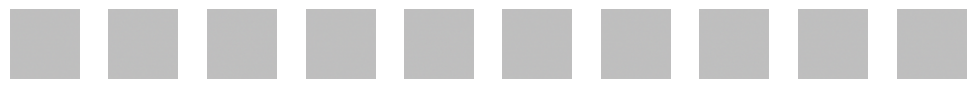

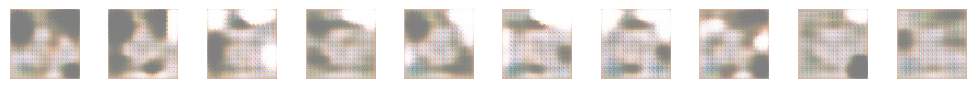

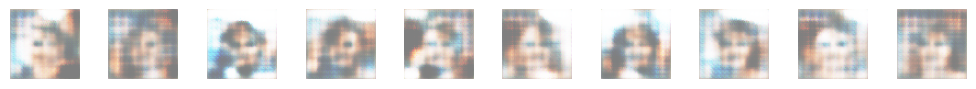

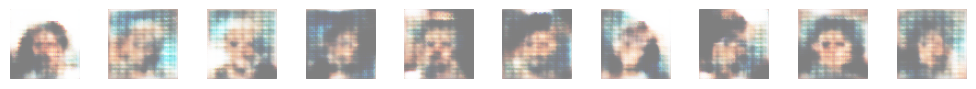

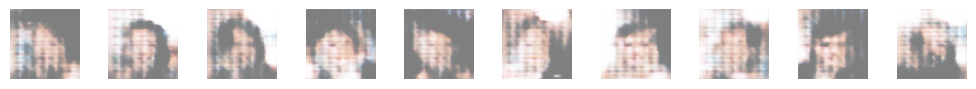

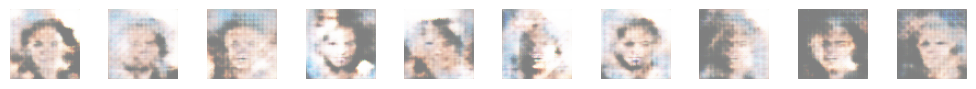

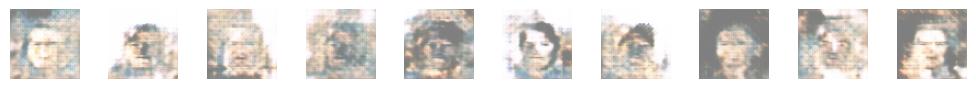

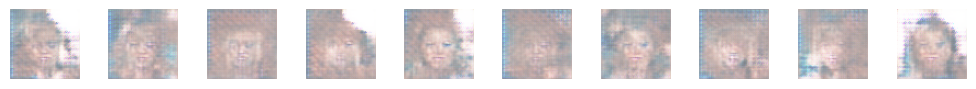

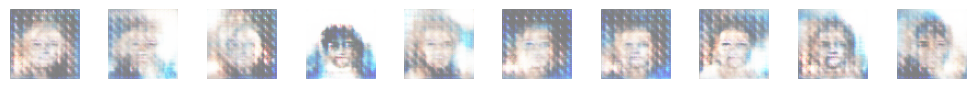

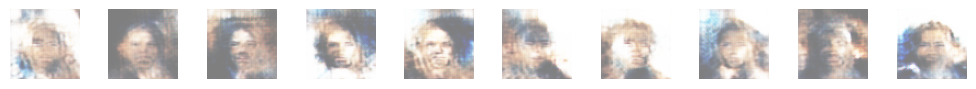

In [8]:
def train_gan(gan, generator, discriminator, x_train, epochs=10000, batch_size=128):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Latih Discriminator
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Latih Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)  # Generator berusaha membuat Discriminator berpikir gambar adalah nyata

        g_loss = gan.train_on_batch(noise, valid_y)

        if epoch % 1000 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
            save_imgs(generator, epoch)

def save_imgs(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images * 0.5 + 0.5  # Skala kembali ke rentang [0, 1]

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((generated_images[i] * 127.5 + 127.5).astype(np.uint8))  # Konversi kembali ke uint8
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")

train_gan(gan, generator, discriminator, x_train)